# **Tabular Playground Series - Aug 2022**

https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/

In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: marianocaccavale
Your Kaggle Key: ··········


100%|██████████| 2.27M/2.27M [00:00<00:00, 141MB/s]


Extracting archive ./tabular-playground-series-aug-2022/tabular-playground-series-aug-2022.zip to ./tabular-playground-series-aug-2022


In [4]:
train_dataset_path = "./tabular-playground-series-aug-2022/train.csv"
test_dataset_path = "./tabular-playground-series-aug-2022/test.csv"
sample_submission = "./tabular-playground-series-aug-2022/sample_submission.csv"

In [62]:
train_ds = pd.read_csv(train_dataset_path, index_col = "id")
test_ds = pd.read_csv(test_dataset_path, index_col = "id")

In [6]:
train_ds.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [7]:
test_ds.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
id,,,,,,,,,,,,,,,,,,,,,
26570,F,119.57,material_5,material_6,6,4,6,9,6,19.305,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
26571,F,113.51,material_5,material_6,6,4,11,8,0,17.883,...,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
26572,F,112.16,material_5,material_6,6,4,8,12,4,18.475,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
26573,F,112.72,material_5,material_6,6,4,8,11,10,16.518,...,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
26574,F,208.00,material_5,material_6,6,4,14,16,8,17.808,...,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044


In [78]:
X_train = train_ds.copy()
y_train = X_train.pop("failure")

X_test = test_ds.copy()

In [19]:
def fillNaN(X):
  for col in X.columns:
    if X[col].dtype == "int64" or X[col].dtype == "float64":
      X[col] = X[col].fillna(X[col].mean())
    else:
      X[col] = X[col].fillna(X[col].mode()[0])
  
  return X

In [20]:
def calc_mi_scores(X, y, discrete_features):
  mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features)
  mi_scores = pd.Series(data = mi_scores, index = X.columns)
  mi_scores.sort_values(ascending = True)
  return mi_scores

In [21]:
def plot_mi_scores(scores):
    plt.figure(dpi=100, figsize=(10, 14))
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Punteggi Mutual Information")

Calcolo i punteggi di informazione mutuale delle feature senza modificarle toccarle.

In [64]:
X_train = fillNaN(X_train)
X_test = fillNaN(X_test)

for col in X_train.select_dtypes("object"):
  X_train[col], _ = X_train[col].factorize()

for col in X_test.select_dtypes("object"):
  X_test[col], _ = X_test[col].factorize()

discrete_features = X_train.columns == int

mi_scores = calc_mi_scores(X_train, y_train, discrete_features)

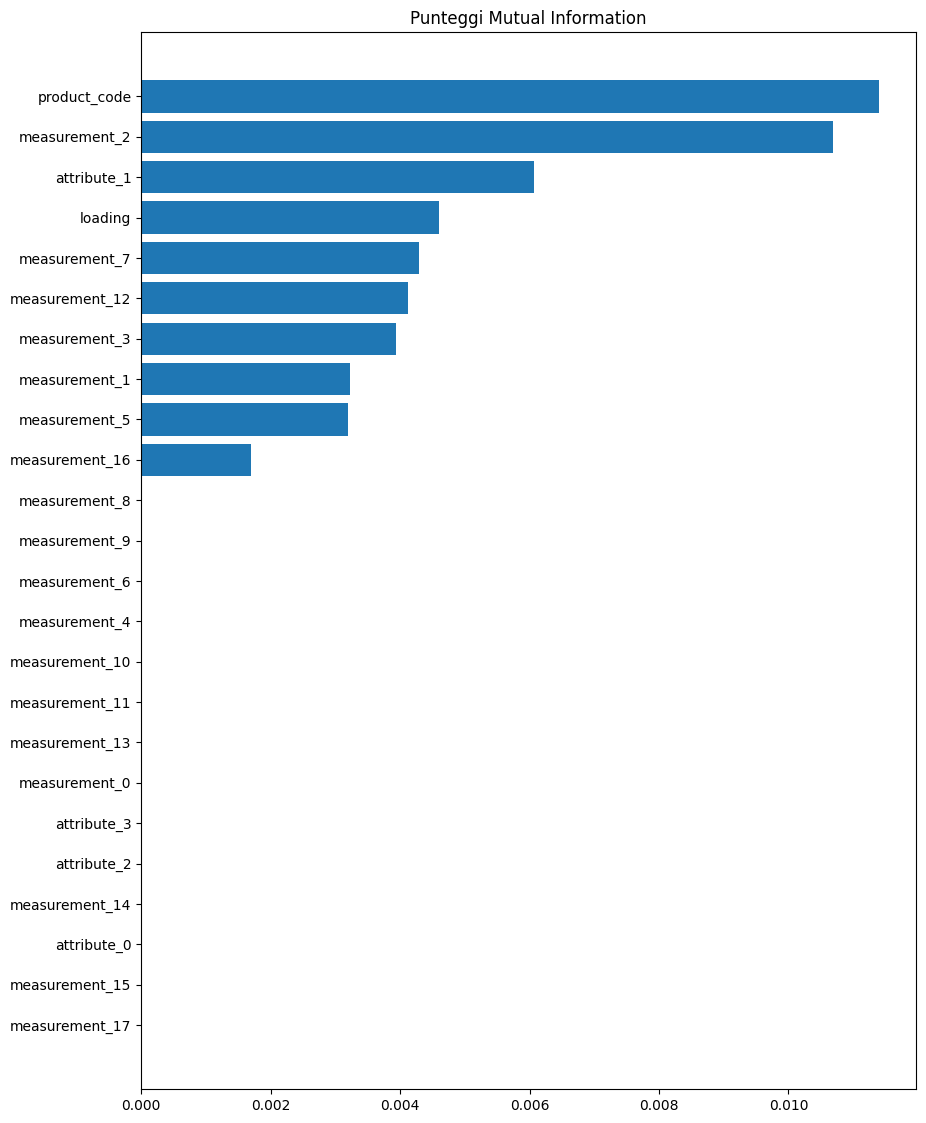

In [23]:
plot_mi_scores(mi_scores)

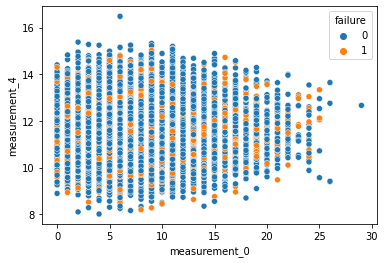

In [38]:
sns.scatterplot(x = "measurement_0", y = "measurement_4", data = train_ds, hue = "failure")

In [65]:
def apply_pca(X, standardize=True):
    # Standardizzo i valori, dato che il PCA lavora (praticamente solo) su valori standardizzati 
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Creo il dataframe risultate
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Creo i loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # faccio la transposta della matrice dei componenti
        columns=component_names,  # in modo che le colonne saranno i componenti stessi
        index=X.columns,  # mentre le righe le feature originali
    )
    return pca, X_pca, loadings

In [68]:
pca, X_pca, _ = apply_pca(X_train)

In [69]:
X_train = X_train.join(X_pca)

In [70]:
X_train

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
id,,,,,,,,,,,,,,,,,,,,,
0,0,80.10,0,0,9,5,7,8,4,18.040,...,0.318118,-0.103129,1.452642,-0.535444,-1.070304,0.191822,-0.424975,-0.076917,-0.281737,8.733572e-13
1,0,84.89,0,0,9,5,14,3,3,18.213,...,0.510082,-1.199802,-0.081830,-0.447176,0.898128,-0.038636,-0.570970,-0.382188,-0.263317,-6.781401e-16
2,0,82.43,0,0,9,5,12,1,5,18.057,...,-1.691304,1.623629,-0.099819,-0.383157,0.112802,-0.563735,-0.093926,-0.391026,-0.236373,6.537780e-16
3,0,101.07,0,0,9,5,13,2,6,17.295,...,0.518800,-0.075824,-0.266245,-0.023454,0.734219,-0.313677,-0.940631,-0.294997,-0.345991,1.454455e-14
4,0,188.06,0,0,9,5,9,2,8,19.346,...,2.122445,-0.868998,-0.647581,-0.247655,-0.579384,-0.414962,-0.168389,0.162946,-0.303177,1.733429e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,4,158.95,0,2,6,9,6,16,4,16.301,...,-1.005514,1.577209,0.349524,0.782207,0.403632,0.909195,-1.145405,0.288853,-0.427333,1.613922e-16
26566,4,146.02,0,2,6,9,10,12,8,17.543,...,1.378703,1.004150,-0.210934,0.840656,0.960349,0.883689,0.079418,0.129119,-0.457618,-2.969732e-17
26567,4,115.62,0,2,6,9,1,10,1,15.670,...,0.276100,-1.060585,-0.733729,0.856064,0.419671,-1.102638,-1.098126,0.254586,-0.240599,-6.405697e-17


In [71]:
for col in X_train.select_dtypes("object"):
  X_train[col], _ = X_train[col].factorize()

discrete_features = X_train.columns == int

mi_scores = calc_mi_scores(X_train, y_train, discrete_features)

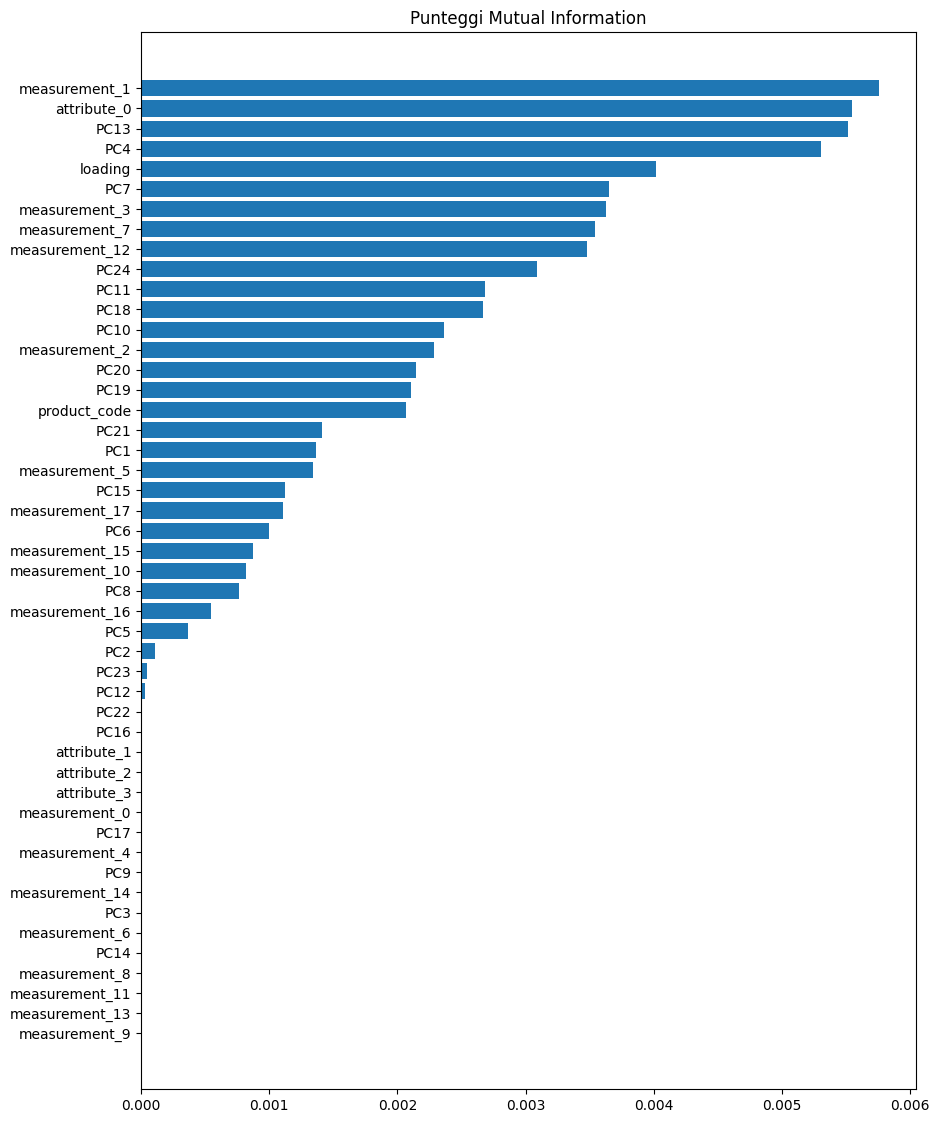

In [72]:
plot_mi_scores(mi_scores)

In [85]:
X_test = test_ds.copy()
X_test = fillNaN(X_test)

for col in X_test.select_dtypes("object"):
  X_test[col], _ = X_test[col].factorize()

_, X_pca_test, _ = apply_pca(X_test)

X_pca_test.index = X_test.index

X_test = X_test.join(X_pca_test)

In [86]:
X_test

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
id,,,,,,,,,,,,,,,,,,,,,
26570,0,119.57,0,0,6,4,6,9,6,19.305,...,-0.119356,-1.187019,-0.625194,-0.085298,-0.851923,0.523636,-0.797281,-0.131041,4.745410e-13,-2.938131e-16
26571,0,113.51,0,0,6,4,11,8,0,17.883,...,1.120151,-0.556723,1.052566,0.873285,0.554041,1.371606,-1.535557,0.677156,-2.399708e-16,-4.694099e-16
26572,0,112.16,0,0,6,4,8,12,4,18.475,...,-0.386087,1.809582,-1.163163,0.657086,-0.102638,0.027955,-1.090486,-0.361621,-1.312127e-14,3.730198e-15
26573,0,112.72,0,0,6,4,8,11,10,16.518,...,-1.008853,-0.443668,0.053650,0.279803,-0.436746,-0.821398,-0.074567,0.035507,-1.718434e-14,6.026417e-15
26574,0,208.00,0,0,6,4,14,16,8,17.808,...,1.138499,-0.847180,0.352927,0.684699,1.046074,-0.166992,0.246916,0.126456,-7.564887e-17,-9.687631e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47340,3,144.74,1,2,9,5,0,4,9,18.465,...,-0.899739,0.108282,0.646856,-0.165433,-1.041279,-0.317666,-0.932491,0.264911,-1.189868e-16,-1.350298e-16
47341,3,74.53,1,2,9,5,4,8,7,18.900,...,-1.072987,-1.029803,-0.252337,0.782361,-0.125924,-1.466009,-0.162345,-0.323851,-3.273677e-16,-1.400432e-16
47342,3,67.73,1,2,9,5,10,11,2,18.656,...,0.604859,-0.600374,-1.537453,-0.396868,1.174624,-0.540122,-0.554523,0.014609,-1.543139e-16,-1.297696e-16


In [88]:
model1 = XGBClassifier()

In [52]:
for mi_score in mi_scores.index:
  if mi_scores[mi_score] <= 0:
    X_train.pop(mi_score)
    X_test.pop(mi_score)

In [89]:
model1.fit(X_train, y_train)

XGBClassifier()

In [ ]:
model2.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [54]:
xgb_score = cross_val_score(model1, X_train, y_train, cv = 3)
#rf_score = cross_val_score(model2, X_train, y_train, cv = 3)

In [55]:
print(xgb_score.mean())
#print(rf_score.mean())

0.7872412418440042


In [56]:
model1.fit(X_train, y_train)

XGBClassifier()

In [90]:
y_hat_test_xgb = model1.predict(X_test)

In [91]:
y_hat_test_xgb

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y_hat_test_rf = model2.predict(X_test)

In [ ]:
y_hat_test_rf

array([0, 0, 0, ..., 0, 0, 0])

In [92]:
submission = pd.read_csv(sample_submission)

In [ ]:
X_test.head()

In [ ]:
submission

,id,failure
0,26570,0.0
1,26571,0.0
2,26572,0.0
3,26573,0.0
4,26574,0.0
...,...,...
20770,47340,0.0
20771,47341,0.0
20772,47342,0.0
20773,47343,0.0


In [93]:
submission["failure"] = y_hat_test_xgb

In [ ]:
submission

,id,failure
0,26570,0
1,26571,0
2,26572,0
3,26573,0
4,26574,0
...,...,...
20770,47340,0
20771,47341,0
20772,47342,0
20773,47343,0


In [94]:
  submission.to_csv("./submission_tabular_playground_series_aug_2022.csv", index = False, encoding='utf-8-sig')